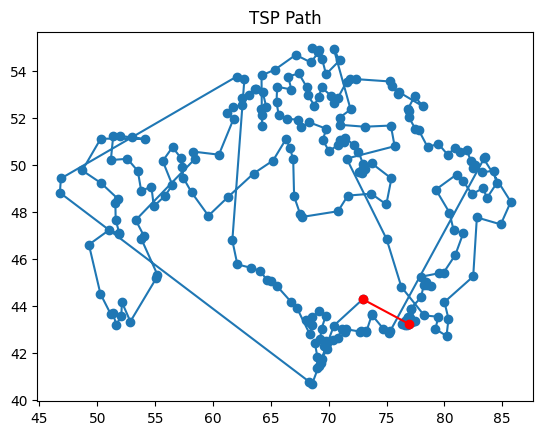

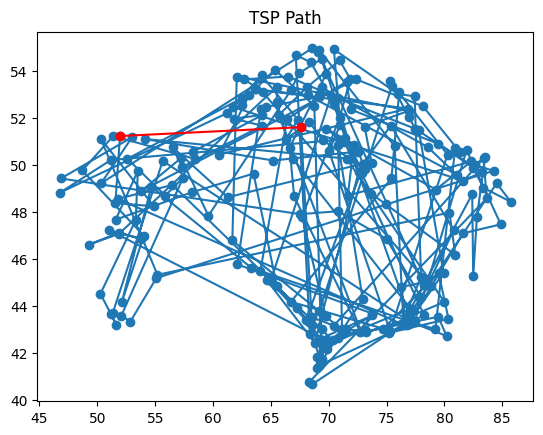

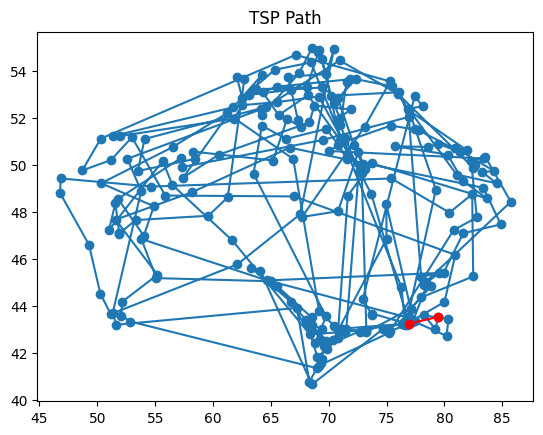

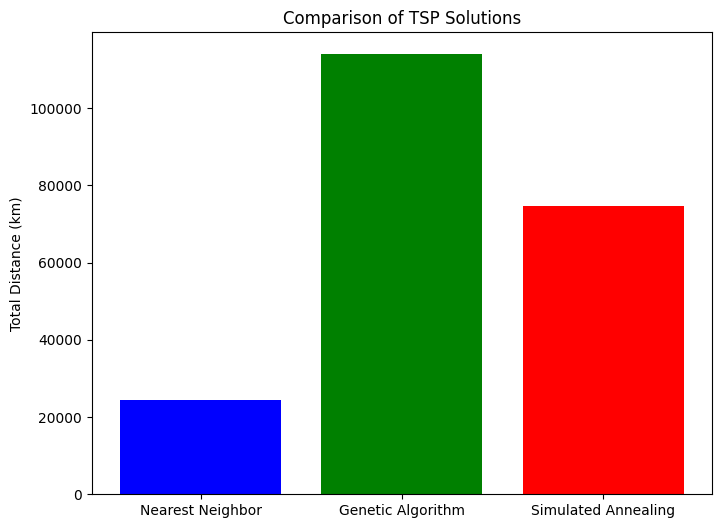

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import cdist

df = pd.read_csv("kz.csv")

# Haversine formula to calculate the distance between two lat/lng coordinates
def haversine(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# Calculate the distance matrix (distance between every pair of cities)
coords = df[['lat', 'lng']].values
dist_matrix = cdist(coords, coords, metric=haversine)

# Step 2: Implement TSP algorithms

# Nearest Neighbor algorithm
def nearest_neighbor(dist_matrix):
    n = len(dist_matrix)
    visited = [False] * n
    tour = [0]
    visited[0] = True
    for _ in range(n - 1):
        last_visited = tour[-1]
        nearest_city = np.argmin([dist_matrix[last_visited][i] if not visited[i] else np.inf for i in range(n)])
        tour.append(nearest_city)
        visited[nearest_city] = True
    return tour

# Genetic Algorithm (simplified version)
def genetic_algorithm(dist_matrix, population_size=100, generations=500, mutation_rate=0.1):
    n = len(dist_matrix)
    
    # Create initial population
    population = [np.random.permutation(n) for _ in range(population_size)]
    
    def fitness(tour):
        return np.sum([dist_matrix[tour[i], tour[i+1]] for i in range(n-1)]) + dist_matrix[tour[-1], tour[0]]

    def crossover(parent1, parent2):
        point = random.randint(1, n - 1)
        child = [-1] * n
        child[:point] = parent1[:point]
        fill = [x for x in parent2 if x not in child]
        child[point:] = fill
        return child

    def mutate(tour):
        if random.random() < mutation_rate:
            i, j = random.sample(range(n), 2)
            tour[i], tour[j] = tour[j], tour[i]
        return tour

    best_tour = None
    best_fitness = float('inf')
    
    # Evolution loop
    for _ in range(generations):
        # Select parents based on fitness (tournament selection)
        population = sorted(population, key=lambda x: fitness(x))
        next_generation = population[:population_size // 2]
        next_generation += [mutate(crossover(random.choice(next_generation), random.choice(next_generation))) for _ in range(population_size // 2)]
        population = next_generation
        
        # Track the best solution
        current_best = population[0]
        current_fitness = fitness(current_best)
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            best_tour = current_best
    
    return best_tour

# Simulated Annealing algorithm
def simulated_annealing(dist_matrix, temp=10000, cooling_rate=0.995, iterations=10000):
    n = len(dist_matrix)
    
    # Generate initial solution (random permutation)
    current_solution = np.random.permutation(n)
    current_cost = np.sum([dist_matrix[current_solution[i], current_solution[i+1]] for i in range(n-1)]) + dist_matrix[current_solution[-1], current_solution[0]]
    
    best_solution = current_solution
    best_cost = current_cost
    
    for i in range(iterations):
        # Make a neighboring solution (swap two cities)
        new_solution = current_solution.copy()
        i, j = random.sample(range(n), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        
        # Calculate cost
        new_cost = np.sum([dist_matrix[new_solution[i], new_solution[i+1]] for i in range(n-1)]) + dist_matrix[new_solution[-1], new_solution[0]]
        
        # Accept the new solution with probability based on temperature
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):
            current_solution = new_solution
            current_cost = new_cost
        
        # Track the best solution
        if current_cost < best_cost:
            best_solution = current_solution
            best_cost = current_cost
        
        # Cool the system
        temp *= cooling_rate
    
    return best_solution

# Step 3: Visualizations

def create_gif(path, dist_matrix, file_name):
    fig, ax = plt.subplots()
    ax.set_title("TSP Path")
    
    def update(frame):
        ax.clear()
        ax.set_title("TSP Path")
        cities_ordered = [df.iloc[i] for i in path[:frame]]
        lats = [city['lat'] for city in cities_ordered]
        lngs = [city['lng'] for city in cities_ordered]
        ax.plot(lngs, lats, marker='o')
        
        # Only plot the closing edge in the last frame
        if frame == len(path):
            ax.plot([lngs[-1], lngs[0]], [lats[-1], lats[0]], marker='o', color='r')
        
        return ax

    ani = FuncAnimation(fig, update, frames=len(path)+1, repeat=False)
    ani.save(file_name, writer='pillow', fps=2)
    
# Step 4: Compute results and visualize

# Apply all algorithms
nn_tour = nearest_neighbor(dist_matrix)
ga_tour = genetic_algorithm(dist_matrix)
sa_tour = simulated_annealing(dist_matrix)

# Calculate distances for comparison
def calc_distance(tour, dist_matrix):
    return np.sum([dist_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1)]) + dist_matrix[tour[-1], tour[0]]

dist_nn = calc_distance(nn_tour, dist_matrix)
dist_ga = calc_distance(ga_tour, dist_matrix)
dist_sa = calc_distance(sa_tour, dist_matrix)

# Create GIFs for each solution
create_gif(nn_tour, dist_matrix, "./data/nn_solution.gif")
create_gif(ga_tour, dist_matrix, "./data/ga_solution.gif")
create_gif(sa_tour, dist_matrix, "./data/sa_solution.gif")

# Comparison bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Nearest Neighbor', 'Genetic Algorithm', 'Simulated Annealing'], 
        [dist_nn, dist_ga, dist_sa], color=['blue', 'green', 'red'])
plt.ylabel('Total Distance (km)')
plt.title('Comparison of TSP Solutions')
plt.show()


In [5]:
import folium

# Function to create map visualization for a given tour
def create_map_visualization(tour, df, file_name):
    # Start by creating the map centered around the first city
    first_city = df.iloc[tour[0]]
    map_center = [first_city['lat'], first_city['lng']]
    city_map = folium.Map(location=map_center, zoom_start=5)
    
    # Plot the cities
    for i in tour:
        city = df.iloc[i]
        folium.Marker([city['lat'], city['lng']], popup=city['city']).add_to(city_map)
    
    # Plot the path (with lines between cities)
    path_coords = [(df.iloc[i]['lat'], df.iloc[i]['lng']) for i in tour]
    folium.PolyLine(path_coords, color="blue", weight=2.5, opacity=1).add_to(city_map)
    
    # Add the closing edge
    last_city = df.iloc[tour[-1]]
    first_city = df.iloc[tour[0]]
    folium.PolyLine([(last_city['lat'], last_city['lng']), (first_city['lat'], first_city['lng'])], color="red", weight=2.5, opacity=1).add_to(city_map)
    
    # Save the map to an HTML file
    city_map.save(file_name)

# Create map visualizations for each solution
create_map_visualization(nn_tour, df, "./data/nn_solution_map.html")
create_map_visualization(ga_tour, df, "./data/ga_solution_map.html")
create_map_visualization(sa_tour, df, "./data/sa_solution_map.html")

In [9]:
print("Nearest Neighbor Tour:", f"{dist_nn} km")
print("Simulated Annealing Tour:", f"{dist_sa} km")
print("Genetic Algorithm Tour:", f"{dist_ga} km")

Nearest Neighbor Tour: 24516.92715977387 km
Simulated Annealing Tour: 74592.67468709037 km
Genetic Algorithm Tour: 113958.1741911759 km


In [ ]:
library(GA)
library(geosphere)
library(ggplot2)
library(ggrepel)
library(mapdata)
library(gifski)
library(readr)


#Грузим данные
data <- read_csv("C:/Project/BigData/R/data/kz.csv")

#Стартовый город
start_city <- "Arqalyq"
#Индекс для стартового города
start_index <- which(data$city == start_city)

# Функция для расчета расстояний между городами формулы Хаверсина
distance_matrix <- distm(data[, c("lng", "lat")], fun = distHaversine)

fitness_function <- function(order) {
  # Создание переменной для хранения суммарного расстояния, изначально равного нулю.
  total_distance <- 0
  
  # Формируем полный маршрут, добавляя начальный город в начало и конец пути.
  order <- c(start_index, order, start_index)
  
  # Цикл по маршруту для вычисления суммарного расстояния между городами.
  for (i in 1:(length(order) - 1)) {
    # Расстояние извлекается из предрассчитанной матрицы расстояний distance_matrix.
    total_distance <- total_distance + distance_matrix[order[i], order[i + 1]]
  }
  
  # Возвращаем отрицательное значение суммарного расстояния (в км)
  return(-(total_distance / 1000))
}


ga_tsp <- ga(
  type = "permutation",                        # Оптимизация порядка обхода городов
  fitness = fitness_function,                  # Оценка маршрута по общей дистанции
  lower = setdiff(1:nrow(data), start_index),  # Исключаем стартовый город из промежуточных точек
  upper = nrow(data),                          # Верхняя граница индексов городов
  popSize = 20,                               # Число маршрутов в каждом поколении
  maxiter = 1000,                             # Максимум поколений
  run = 500                                    # Остановка, если нет улучшений в 500 поколений
)

best_solution <- ga_tsp@solution
best_value <- -ga_tsp@fitnessValue

# Извлечение оптимального маршрута
best_route <- c(start_index, ga_tsp@solution[1, ], start_index)

# Визуализация оптимального маршрута на карте Казахстана
world_map <- map_data("world")

# Создаем пустой график
ggplot() +
  geom_polygon(data = world_map, aes(x = long, y = lat, group = group), fill = "lightgray", color = "white") +
  coord_fixed(xlim = c(45, 90), ylim = c(40, 56), ratio = 1.3) +
  geom_path(data = data[best_route, ], aes(x = lng, y = lat), color = "red", size = 1) +
  geom_point(data = data, aes(x = lng, y = lat), color = "blue", size = 3) +
  geom_text_repel(data = data, aes(x = lng, y = lat, label = city), size = 3, color = "darkblue", max.overlaps = Inf, nudge_y = 0.2) +
  labs(title = "Оптимальный маршрут коммивояжера по городам Казахстана", x = "Долгота", y = "Широта") +
  theme_minimal()



path <- "C:/Project/BigData/R/frames2"
dir.create(path, showWarnings = TRUE)

# Создаем кадры
for (i in 1:length(best_route)) {
  p <- ggplot() +
    geom_polygon(data = world_map, aes(x = long, y = lat, group = group), fill = "lightgray", color = "white") +
    coord_fixed(xlim = c(45, 90), ylim = c(40, 56), ratio = 1.3) +
    geom_path(data = data[best_route[1:i], ], aes(x = lng, y = lat), color = "red", size = 1) +  # маршрут
    geom_point(data = data[best_route[1:i], ], aes(x = lng, y = lat), color = "blue", size = 3) +
    geom_text_repel(data = data[best_route[1:i], ], aes(x = lng, y = lat, label = city), size = 3, color = "darkblue") +
    labs(title = paste("Кадр", i, "из", length(best_route)), x = "Долгота", y = "Широта") +
    theme_minimal()
  
  # Сохраняем кадры
  ggsave(filename = paste0("C:/Project/BigData/R/frames2/frame_", sprintf("%03d", i), ".png"), plot = p, width = 10, height = 6)
}

# Создаем GIF из кадров
gifski(png_files = list.files(path, full.names = TRUE), 
       gif_file = "C:/Project/BigData/R/tsp_route2.gif", 
       width = 1920, height = 1080, delay = 0.2)
